# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

np.set_printoptions(linewidth=np.inf, precision=2)

This function is to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

## Load the dataframe


Load the data


In [3]:
from os.path import exists

if exists('./data/spacex_dataset2.csv'):
    data = pd.read_csv('./data/spacex_dataset2.csv')
else:
    path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv'
    data = pd.read_csv(path)
    
print(data.shape)
data.head()

(90, 18)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
if exists('./data/spacex_dataset3.csv'):
    X = pd.read_csv('./data/spacex_dataset3.csv')
else:
    x_path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
    X = pd.read_csv(x_path)
    
print(X.shape)
X.head(5)

(90, 80)


,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [5]:
Y = data.Class.to_numpy()
Y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [6]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X[0][0:10]

array([-1.71,  0.  , -0.65, -1.87, -0.84, -1.93, -1.58, -0.79, -0.11, -0.11])

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  Y_train.shape, '\n' 'Test set:', X_test.shape,  Y_test.shape)

Train set: (72, 80) (72,) 
Test set: (18, 80) (18,)


we can see we only have 18 test samples.


## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [8]:
parameters ={'C': [0.01,0.1,1], 'penalty': ['l2'], 'solver': ['lbfgs']}  # l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, param_grid=parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [9]:
print('tuned hpyerparameters :(best parameters)', logreg_cv.best_params_)
print('accuracy :',logreg_cv.best_score_)

tuned hpyerparameters :(best parameters) {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8339285714285714


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [10]:
logreg_cv.score(X_test, Y_test)

0.7777777777777778

Lets look at the confusion matrix:


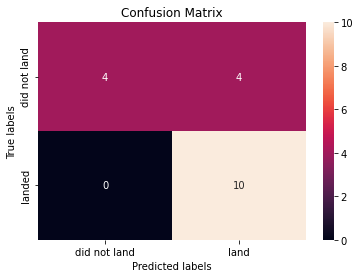

In [11]:
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
parameters = {'kernel': ('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma': np.logspace(-3, 3, 5)}
svm = SVC()

svm_cv = GridSearchCV(svm, param_grid=parameters, cv=10)
svm_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8625


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [13]:
svm_cv.score(X_test, Y_test)

0.7777777777777778

We can plot the confusion matrix


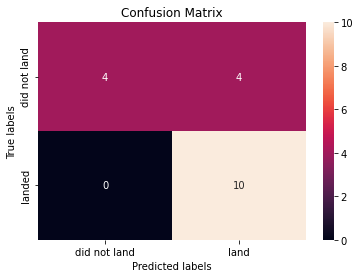

In [14]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [15]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [16]:
tree_cv = GridSearchCV(tree, param_grid=parameters, cv=10)
tree_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ", tree_cv.best_params_)
print("accuracy :", tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 16, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.9196428571428571


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [17]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


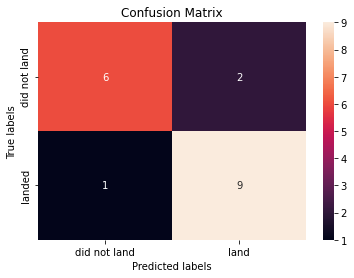

In [18]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [19]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [20]:
knn_cv = GridSearchCV(KNN, param_grid=parameters, cv=10)
knn_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ", knn_cv.best_params_)
print("accuracy :", knn_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 4, 'p': 1}
accuracy : 0.8232142857142856


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [21]:
knn_cv.score(X_test, Y_test)

0.7777777777777778

We can plot the confusion matrix


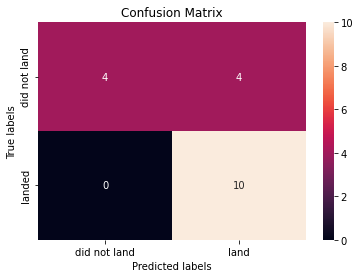

In [22]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:

### Model accuracy comparison

Text(0, 0.5, 'Accuracy Score')

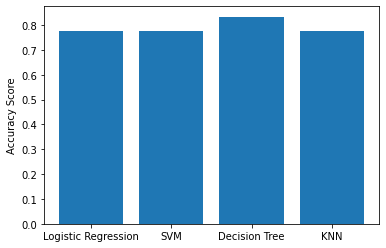

In [24]:
models = ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN']
accuracies = [logreg_cv.score(X_test, Y_test), svm_cv.score(X_test, Y_test),
             tree_cv.score(X_test, Y_test), knn_cv.score(X_test, Y_test)]

plt.bar(models, accuracies)
plt.ylabel('Accuracy Score')

Based on the plot above, Decision Tree seems to perform marginally better than other models in this scenario. However, the difference in performance is very small, and perhaps dependent on how the data is split. For example, if random state is set to 2 while splitting the data, Logistic Regression and SVM outperform the other two models by a small margin. Considering this, it can be concluded that for the current data, all models perform more or less the same.